In [16]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from liquidity.util.utils import compute_returns
from notebooks.util.long_memory_utils import compute_and_load_acf, plot_acf_difference

from powerlaw_function.powerlaw_function import Fit

from hurst_exponent.acf import linear_acf, nonlinear_acf
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller
from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst

In [17]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Number of events to use
EVENTS_RANGE = 1000000

# Number of lags for the ACF
ACF_RANGE = 1001

## Load raw sample data

In [12]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Compute Returns

In [5]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns'].head(EVENTS_RANGE)
msft_returns = compute_returns(msft_raw_df)['returns'].head(EVENTS_RANGE)
amzn_returns = compute_returns(amzn_raw_df)['returns'].head(EVENTS_RANGE)
nflx_returns = compute_returns(nflx_raw_df)['returns'].head(EVENTS_RANGE)
ebay_returns = compute_returns(ebay_raw_df)['returns'].head(EVENTS_RANGE)
appl_returns = compute_returns(appl_raw_df)['returns'].head(EVENTS_RANGE)

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}

## 2. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [ ]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data, stock)

## 3. Autocorrelation Functions

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.

**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.


In [7]:
# # Save data for lazy loading
# acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data')
# linear_filename = f"{acf_data_dir}/mo_returns_linear_acfs.pkl"
# nonlinear_filename = f"{acf_data_dir}/mo_returns_nonlinear_acfs.pkl"
#
# if not os.path.exists(linear_filename) or not os.path.exists(nonlinear_filename):
#
#     # Use pathos for parallel processing
#     from pathos.multiprocessing import ProcessingPool
#
#     # Define a function that computes linear and nonlinear ACF for each stock.
#     def compute_acf(stock_series):
#         stock, series = stock_series
#
#         linear_result = linear_acf(series, ACF_RANGE)
#         nonlinear_result = nonlinear_acf(series, ACF_RANGE)
#
#         return stock, linear_result, nonlinear_result
#
#     pool = ProcessingPool(processes=4)  # adjust the number of processes as needed
#     results = pool.map(compute_acf, returns.items())
#     pool.close()
#     pool.join()
#
#     # Organize results
#     linear_acf_results = {}
#     nonlinear_acf_results = {}
#     for stock, linear_result, nonlinear_result in results:
#         linear_acf_results[stock] = linear_result
#         nonlinear_acf_results[stock] = nonlinear_result
#
#     # Save data for lazy loading
#     pickle.dump(linear_acf_results, open(linear_filename, "wb"))
#     pickle.dump(nonlinear_acf_results, open(nonlinear_filename, "wb"))
#
# # Load data
# linear_acfs = pickle.load(open(linear_filename, "rb"))
# nonlinear_acfs = pickle.load(open(nonlinear_filename, "rb"))
# nonlinear_acfs.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [13]:
# # Save data for lazy loading
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data')
linear_filename = f"{acf_data_dir}/mo_returns_linear_acfs.pkl"
nonlinear_filename = f"{acf_data_dir}/mo_returns_nonlinear_acfs.pkl"

# Linear ACF
linear_acfs = compute_and_load_acf(linear_filename, returns, option='linear')
print(linear_acfs.keys())

# Nonlinear ACF
nonlinear_acfs = compute_and_load_acf(nonlinear_filename, returns, option='nonlinear')
print(nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])
dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


TSLA Max difference: 0.0014872265680442105


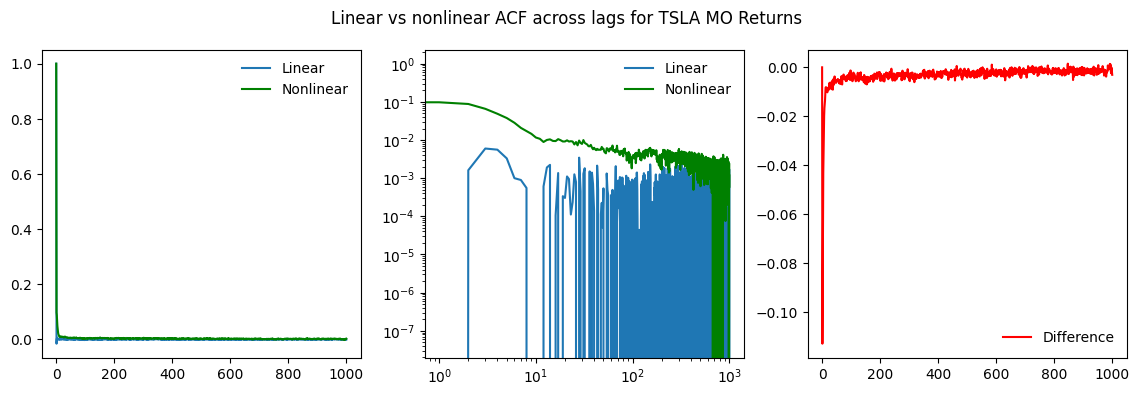

MSFT Max difference: 0.019841888711631707


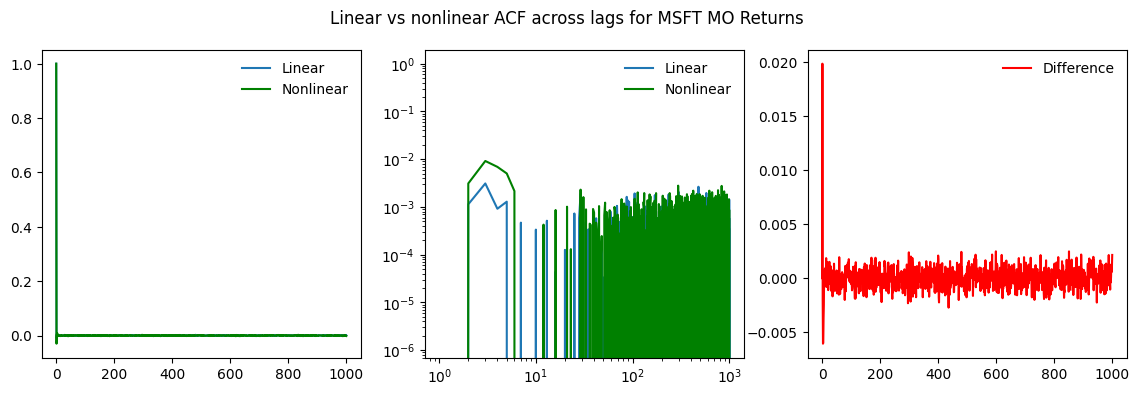

AMZN Max difference: 0.0


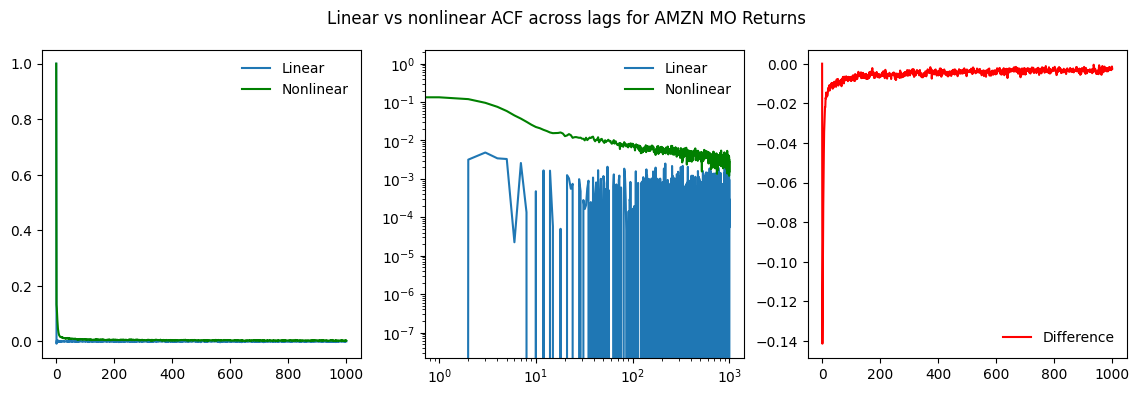

NFLX Max difference: 0.002096253246492851


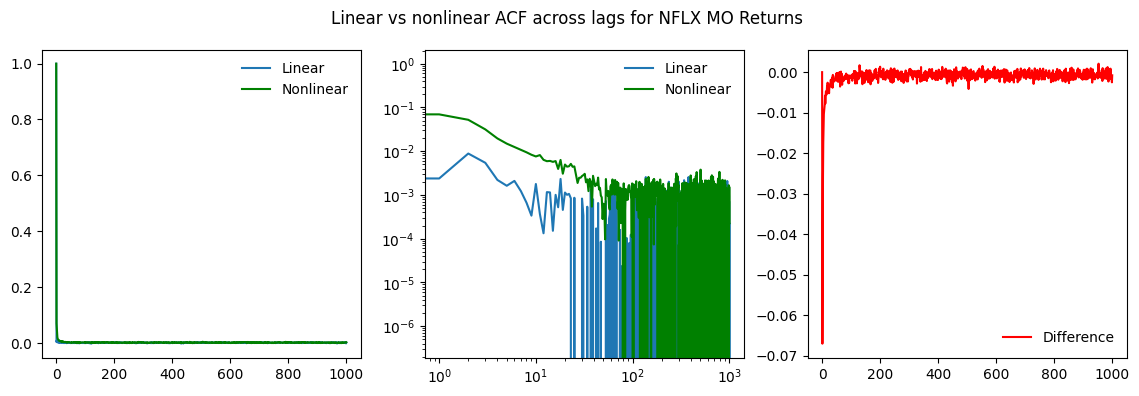

EBAY Max difference: 0.02629526705388381


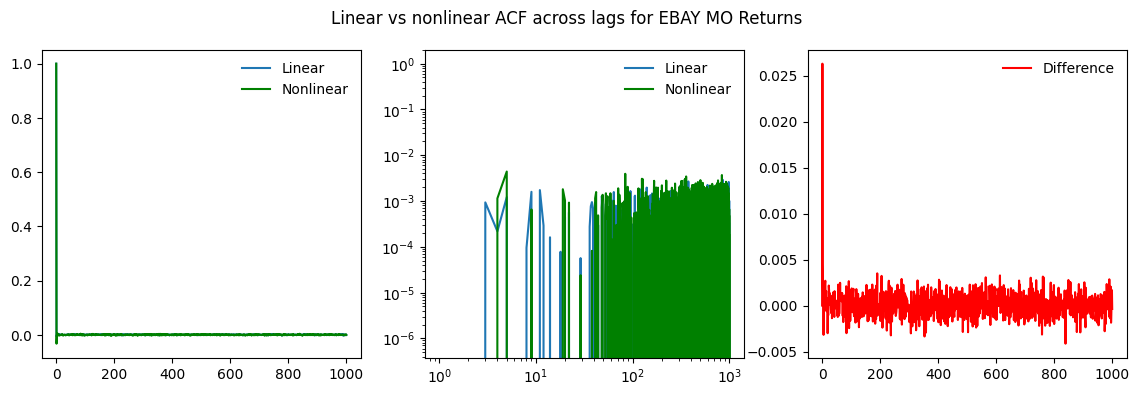

APPL Max difference: 0.0006466608916848478


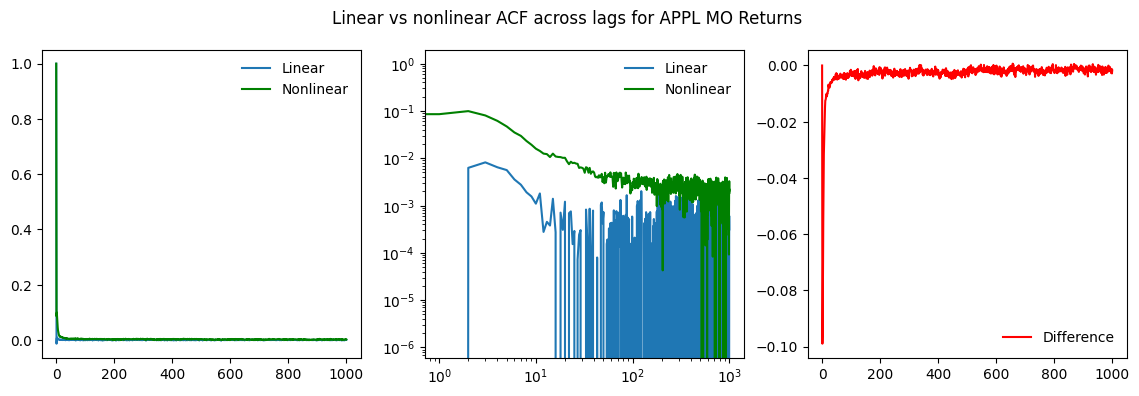

In [20]:
# Plot differences
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs, acf_range=ACF_RANGE)

## 4. The Long Memory of Returns
To determine if a process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard anf generalized hurst on raw series.

### 4.1. Estimate ACF scaling parameter

In [21]:
# TSLA Example
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin: 6.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.0504239110954098
alpha = -0.5046943591841555

Goodness of fit to data;
D = 0.20883534136546184
bic = -13377.55696211441
mape = 59.982641398292536
Adjusted R-squared = 0.739121588359529




### 4.1.2. For all assets

In [22]:
# Load the pre-computed ACFs
# 1. Construct values for x- and y-axis of our ACF
def construct_xy(sample: pd.Series, name: str) -> pd.DataFrame:
    y_values = list(sample)
    if len(sample) != len(y_values):
        raise ValueError(f"Sample sizes mismatch for {name}.")

    xy_df = pd.DataFrame({
        'x_values': range(1, len(y_values) + 1),
        'y_values': y_values
    })

    return xy_df

return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)


In [23]:
def fit_powerlaw_for_stock(stock_data_tuple):
    stock, data = stock_data_tuple
    fit = Fit(data)  # Constructed DataFrame passed here
    fit_dict = fit.powerlaw.to_dictionary()

    if fit_dict.get("function_name") == "powerlaw":
        alpha = fit.powerlaw.params.alpha  # Extract 'alpha'
        fit_dict.update({
            'alpha': alpha,
            'stock': stock
        })
        return fit_dict, fit  # Return both dictionary and fit object
    return None, None

fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

for stock, data in return_acf_values.items():
    fit_dict, fit_obj = fit_powerlaw_for_stock((stock, data))
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[stock] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
acf_fit_results

KeyboardInterrupt: 

In [ ]:
fit_objects.keys()

In [ ]:
# Retrieve the fit object for 'STOCK':
# tsla_acf_fit = fit_objects['AMZN']
# tsla_acf_fit.powerlaw.plot_fit()

In [ ]:
avg_alpha = acf_fit_results['alpha'].mean()
print(f"Average Alpha: {avg_alpha}")

### 4.2. Estimate Hurst Exponent

The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:

- $H = 0.5$: The series is a random walk (Brownian motion). The future values do not depend on the past values.

- $H < 0.5$: The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.

- $H > 0.5$: The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.

In [ ]:
# TSLA Example
tsla_returns = compute_returns(tsla_raw_df)['cumsum_returns']

# Estimate Hurst Exponent using both Standard and Generalized metod
hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()

print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")

### 4.2.1 For all assets

In [ ]:
# Compute cumsum of returns as input for Hurst
tsla_cum_returns = compute_returns(tsla_raw_df, EVENTS_RANGE)['cumsum_returns']
amzn_cum_returns = compute_returns(amzn_raw_df, EVENTS_RANGE)['cumsum_returns']
nflx_cum_returns = compute_returns(nflx_raw_df, EVENTS_RANGE)['cumsum_returns']
msft_cum_returns = compute_returns(msft_raw_df, EVENTS_RANGE)['cumsum_returns']
ebay_cum_returns = compute_returns(ebay_raw_df, EVENTS_RANGE)['cumsum_returns']
appl_cum_returns = compute_returns(appl_raw_df, EVENTS_RANGE)['cumsum_returns']

cumsum_returns = {
  'TSLA': tsla_cum_returns,
  'AMZN': amzn_cum_returns,
  'NFLX': nflx_cum_returns,
  'MSFT': msft_cum_returns,
  'EBAY': ebay_cum_returns,
  'APPL': appl_cum_returns
}
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

In [ ]:
def compute_hurst_for_stock(stock_data_tuple, method='standard'):
    dict_name, stock, data = stock_data_tuple

    if method == 'standard':
        hurst_val, fit = standard_hurst(data)
    elif method == 'generalized':
        hurst_val, fit = generalized_hurst(data, min_lag=12)
    else:
        raise ValueError("Invalid method provided. Choose either 'standard' or 'generalized'.")

    fit_dict = fit.powerlaw.to_dictionary()

    # Update the dictionary with Hurst values and stock name
    if fit_dict.get("function_name") == "powerlaw":
        fit_dict.update({
            f'{method}_hurst': hurst_val,
            'stock': stock,
            'dict_name': dict_name
        })
        return fit_dict, fit
    return None, None

In [ ]:
# Standard Hurst

methods = ['standard']
fit_results_list = []
fit_objects = {}


for method in methods:
    for stock, data in cumsum_returns.items():
        fit_dict, fit = compute_hurst_for_stock(('returns', stock, data), method=method)
        if fit_dict:
            fit_results_list.append(fit_dict)
            fit_objects[(stock, method, 'returns')] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
std_hurst_fit_results


In [ ]:
print(fit_objects.keys())

In [ ]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

In [ ]:
# Retrieve standard Hurst fit object for specific 'STOCK'
# tsla_standard_fit = fit_objects[('TSLA', 'standard', 'returns')]
# tsla_standard_fit.powerlaw.plot_fit()

In [ ]:
# Generalized Hurst

methods = ['generalized']
fit_results_list = []
fit_objects = {}

for method in methods:
    for stock, data in cumsum_returns.items():
        fit_dict, fit = compute_hurst_for_stock(('returns', stock, data), method=method)
        if fit_dict:
            fit_results_list.append(fit_dict)
            fit_objects[(stock, method, 'returns')] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
gen_hurst_fit_results


In [ ]:
print(fit_objects.keys())

In [ ]:
# Retrieve generalized fit object for specific 'STOCK'
# msft_generalized_fit = fit_objects[('TSLA', 'generalized', 'returns')]
# msft_generalized_fit.powerlaw.plot_fit()

In [ ]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()


print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")